# STAT 451 Machine Learning Project: Understanding How Properties in Madison are Assessed
#### Group: Project 16
##### Ahsan Fawwaz (asyraf@wisc.edu), Faris Hazim (mohamedzaimi@wisc.edu), Imran Iskander (biniskanderg@wisc.edu), Nick Elias (nelias@wisc.edu), Tyler Kelly (tpkelly@wisc.edu)

### 0. Import Statements and Data Setup

In [71]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, tree
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

from sklearn.metrics import (precision_score, recall_score,
                             roc_auc_score, RocCurveDisplay)

from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load Data
property_data = pd.read_csv("property.csv", index_col = 0)

# Clean up column with 0 values for tax questions
property_data = property_data[(property_data["FullAmt"] != 0) &
                             (property_data["TotalAssessedValue"] != 0) &
                             (property_data["EstFairMkt"] != 0)]


tr = pd.read_csv("tr.csv", usecols = [0, 1, 3, 5, 7, 9, 11, 13], index_col = 0)

property_data.head(3)

,TaxYear,TotalAssessedValue,MillRate,EstFairMkt,FullAmt,Address,PropertyCl,PropertyUs,AreaName,HomeStyle,...,NoiseAirpo,NoiseRailr,NoiseStree,LandfillPr,geometry,Center,NearestBus,NearestBusStop,DistanceToStop,OnBusLine
Parcel,,,,,,,,,,,,,,,,,,,,,
60801101019,2022,273900,0.019815,286028,5064.51,2001 Rae Ln,Residential,Single family,Meadowood,Ranch,...,0,0,61,0,"POLYGON ((297595.8535932584 4767311.365856603,...",POINT (297620.61661966785 4767321.665650366),"('EB Raymond ns Cameron', 0.03982168293238212)",EB Raymond ns Cameron,0.039822,True
60801101027,2022,274000,0.019815,286132,5066.49,2005 Rae Ln,Residential,Single family,Meadowood,Ranch,...,0,0,61,0,"POLYGON ((297595.8535932584 4767311.365856603,...",POINT (297619.62445800914 4767292.96129518),"('EB Raymond ns Cameron', 0.04895173738850319)",EB Raymond ns Cameron,0.048952,True
60801101035,2022,270500,0.019815,282477,6217.78,2009 Rae Ln,Residential,Single family,Meadowood,Ranch,...,0,0,61,0,POLYGON ((297580.31286357297 4767275.152439604...,POINT (297613.52371822094 4767266.8702369975),"('EB Raymond ns Cameron', 0.0628330914717298)",EB Raymond ns Cameron,0.062833,True


In [3]:
# Shapefile
property_shp = gpd.read_file('Assessor_Property_Information/TaxParcels.shp')[["Parcel", "PropertyCl", "PreviousTo", "geometry"]]

In [4]:
property_shp["Quantile"] = pd.qcut(property_shp["PreviousTo"], q = [0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                  labels = ["Very Low", "Low", "Intermediate", "High", "Very High"])

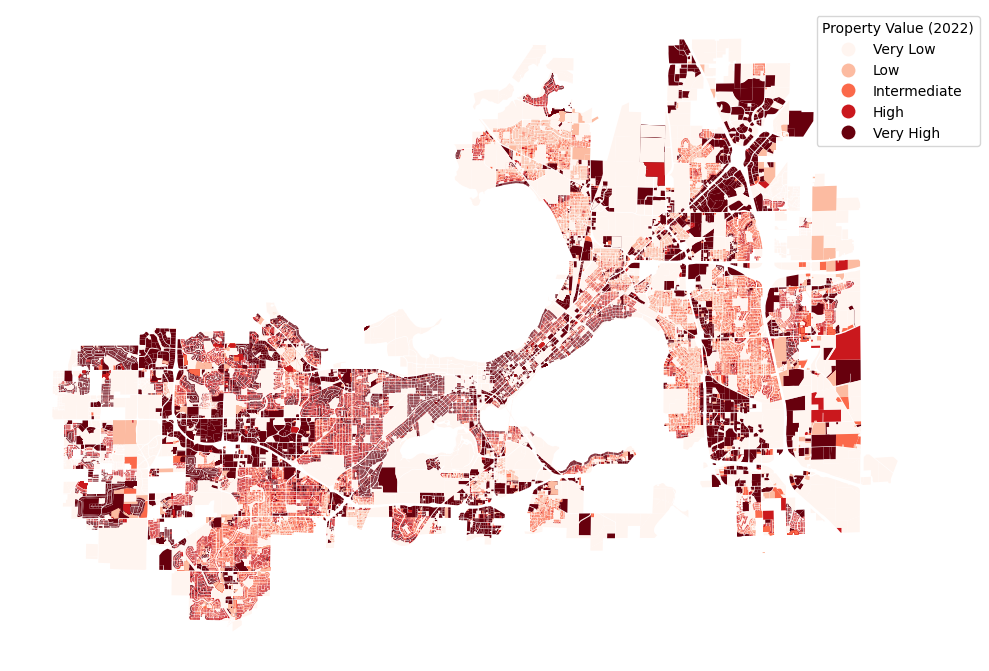

In [5]:
fig, gax = plt.subplots(figsize=(12, 12))

madtown_map = property_shp.plot(ax = gax, column = "Quantile", cmap = "Reds", legend = True)

legend = madtown_map.get_legend()
legend.set_title("Property Value (2022)")
legend.set_bbox_to_anchor((1.05, 1))

gax.axis('off')
plt.savefig("TAV.svg")
plt.show()

### 1. Exploring how taxes vary amongst properties in Madison:


### Question 1(a): Tax Amounts and Property Assessed Values

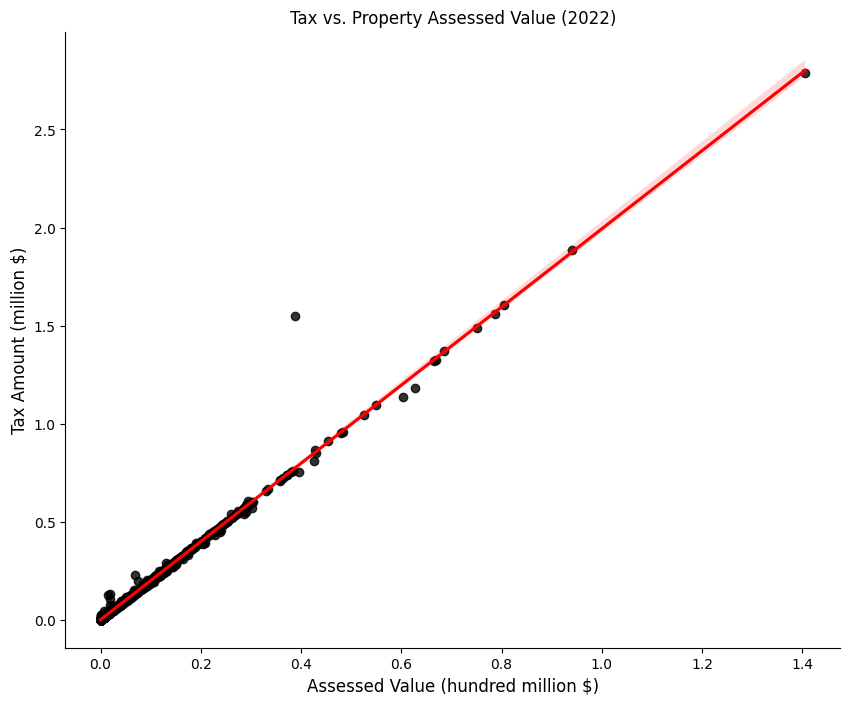

In [6]:
# Scatterplot for Tax Amount vs. Property Value
fig, ax = plt.subplots(figsize=(10, 8))

q1a_subset = property_data[["TotalAssessedValue"]]
y = property_data["FullAmt"]

sns.regplot(x = q1a_subset["TotalAssessedValue"] / 1e8, y = y / 1e6, ax = ax, color = "black",
            line_kws = dict(color = "r"))

plt.title("Tax vs. Property Assessed Value (2022)", fontsize = 12)
plt.xlabel("Assessed Value (hundred million $)", fontsize = 12)
plt.ylabel("Tax Amount (million $)", fontsize = 12)

sns.despine(ax = ax)
plt.savefig("Tax_v_TAV.svg")
plt.show()

### Question 1(b): Tax Rates and Tax Amounts by Property Class

- The mean tax rates across each property class are approximately the same.
- On average, properties in industrial areas pays higher tax compared to commercial, residential, and agricultural respectively in this order.
- However, There is much higher variation in tax amounts for commercial properties compared to industrial, residential, with agricultural having the least.

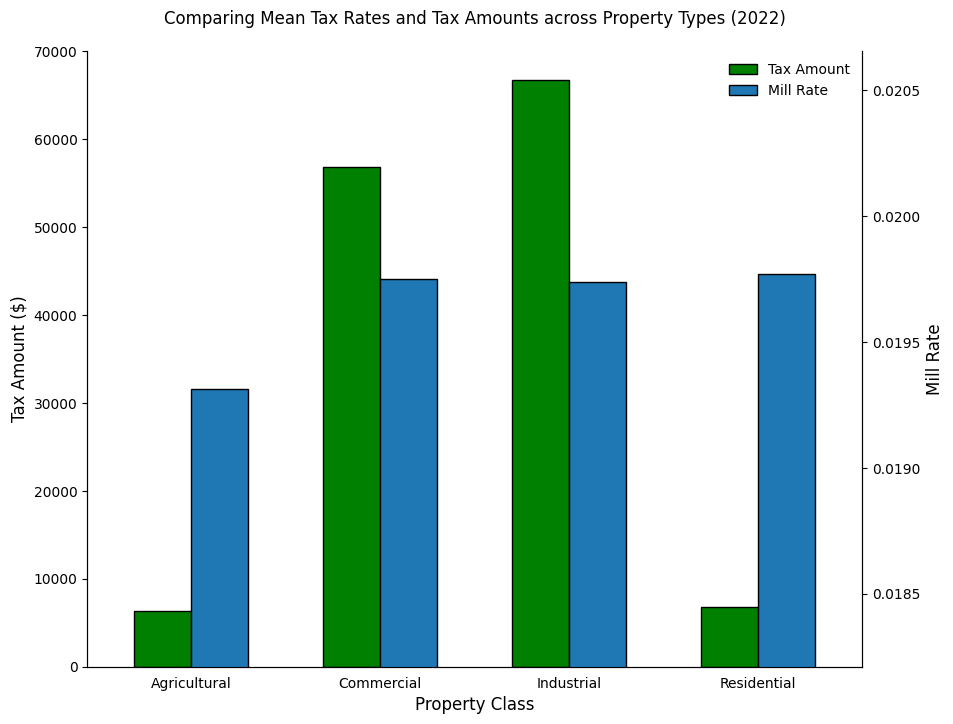

In [7]:
# Cleaning up features
q1b_subset = property_data[property_data["FullAmt"] > 1000].reset_index()[["PropertyCl", "FullAmt", "MillRate"]] # Note that the minimum is 0.28, seems not logical; set 1k as threshold
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

# Creating another pair of axes that shares the same x-axis as ax
ax2 = ax.twinx() 

min_tax_rate = q1b_subset["MillRate"].min()
max_tax_rate = q1b_subset["MillRate"].max()

q1b_subset = q1b_subset.groupby("PropertyCl")[["FullAmt", "MillRate"]].mean()

bar1 = q1b_subset[["FullAmt"]].plot(kind = "bar", ax = ax, color = "green", edgecolor = "black", position = 1, label = "Tax Amount", width = 0.3)
bar2 = q1b_subset[["MillRate"]].plot(kind = "bar", ax = ax2, edgecolor = "black", position = 0, label = "Tax Rate", width = 0.3)

ax2.set_ylim(min_tax_rate, max_tax_rate)
ax.set_xlabel("Property Class", fontsize = 12)
ax.set_ylabel("Tax Amount ($)", fontsize = 12)
ax2.set_ylabel("Mill Rate", fontsize = 12)

xlim = ax.get_xlim()

axs = [ax, ax2]

for a in axs:
    a.set_xlim([xlim[0] - 0.3, xlim[1]]) 
    a.legend().remove()
    a.tick_params(axis = "x", rotation = 0, bottom = False)
    a.spines["top"].set_visible(False)

handles1, _ = ax.get_legend_handles_labels()
handles2, _ = ax2.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles1 + handles2
combined_labels = ["Tax Amount", "Mill Rate"]

# Create a single legend
ax.legend(combined_handles, combined_labels, loc = "upper right", frameon = False)

plt.title("Comparing Mean Tax Rates and Tax Amounts across Property Types (2022)", y = 1.03, fontsize = 12)
plt.savefig("MTR.svg")
plt.show()

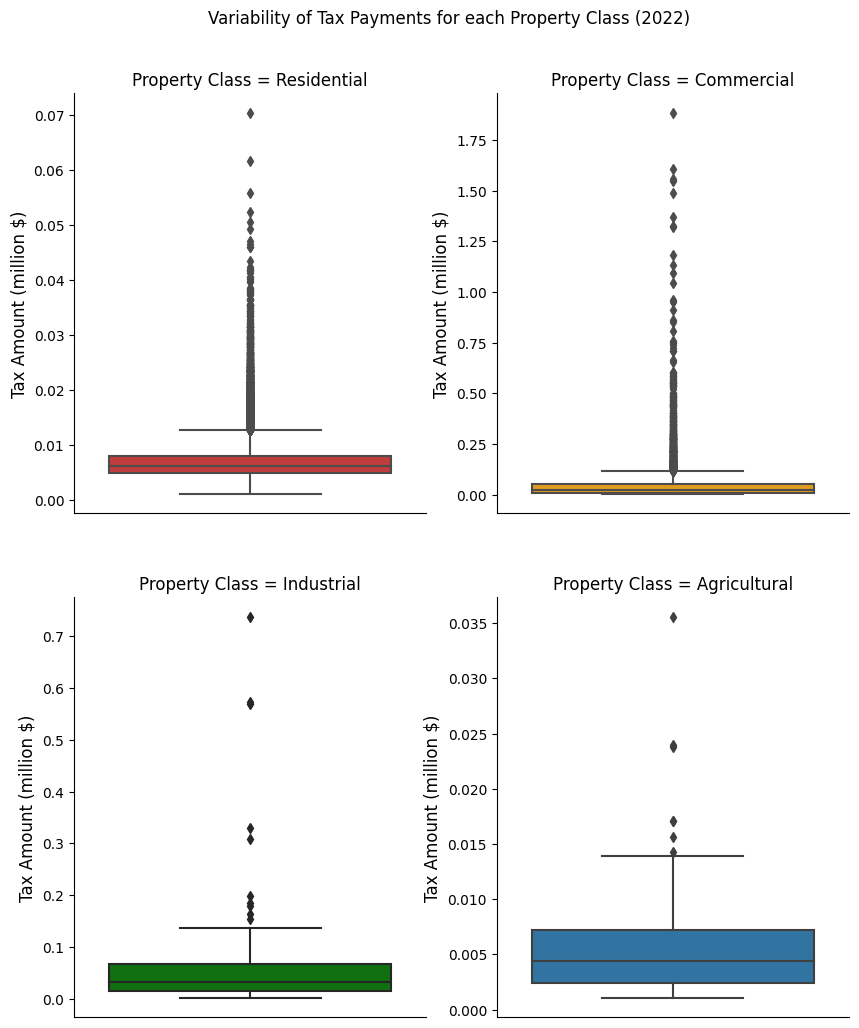

In [8]:
# Cleaning up features
q1b_subset = property_data[property_data["FullAmt"] > 1000].reset_index()[["PropertyCl", "FullAmt"]] # Note that the minimum is 0.28, seems not logical, set 1k as threshold.
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 12))
ax1, ax2, ax3, ax4 = axes.flatten()

p_class = ["Residential", "Commercial", "Industrial", "Agricultural"]
tax_class = []

for p in p_class:
    tax_class.append(q1b_subset[q1b_subset["PropertyCl"] == p])

# Removing extreme outlier
tax_class[1] = tax_class[1][tax_class[1]["FullAmt"] < 2.5*1e6] 

# Plotting box plot
sns.boxplot(y = tax_class[0].set_index("PropertyCl")["FullAmt"] / 1e6, ax = ax1, color = "tab:red")
sns.boxplot(y = tax_class[1].set_index("PropertyCl")["FullAmt"] / 1e6, ax = ax2, color = "orange")
sns.boxplot(y = tax_class[2].set_index("PropertyCl")["FullAmt"] / 1e6, ax = ax3, color = "green")
sns.boxplot(y = tax_class[3].set_index("PropertyCl")["FullAmt"] / 1e6, ax = ax4, color = "tab:blue")

axs = [ax1, ax2, ax3, ax4]
for index, ax in enumerate(axs):
    ax.tick_params(bottom = False)
    ax.set_title(f"Property Class = {p_class[index]}", fontsize = 12)
    ax.set_ylabel("Tax Amount (million $)", fontsize = 12)


plt.suptitle("Variability of Tax Payments for each Property Class (2022)", y = 0.95, fontsize = 12)
sns.despine()
plt.savefig("VarTax.svg")
plt.show()

### Question 1(c): Distribution of Tax Amounts per Property Class


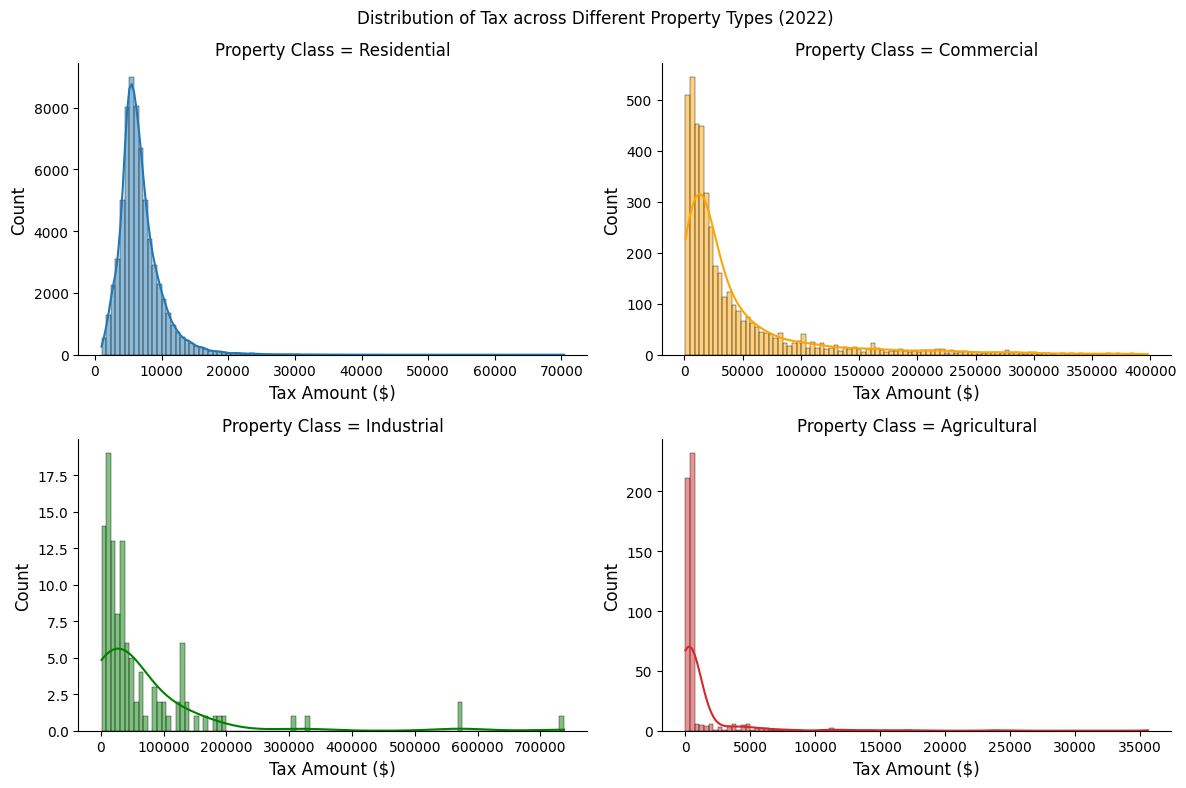

In [9]:
# Residential properties
property_residential = property_data[property_data["PropertyCl"] == "Residential"]
residential_tax = property_residential.FullAmt[property_residential["FullAmt"] > 1000]

# Commercial properties
property_commercial = property_data[property_data["PropertyCl"] == "Commercial"]
commercial_tax = property_commercial.FullAmt[(property_commercial["FullAmt"] > 1000) 
                                                      & (property_commercial["FullAmt"] < 400000)]

# Industrial properties
property_industrial= property_data[property_data["PropertyCl"] == "Industrial"]
industrial_tax = property_industrial.FullAmt[property_industrial["FullAmt"] > 1000]

# Agricultural properties
property_agricultural = property_data[property_data["PropertyCl"] == "Agricultural"]
agricultural_tax = property_agricultural.FullAmt


fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
fig.suptitle("Distribution of Tax across Different Property Types (2022)", fontsize = 12)

taxes = [residential_tax, commercial_tax, industrial_tax, agricultural_tax]
colors = ["tab:blue", "orange", "green", "tab:red"]

for index, ax in enumerate(axs.flatten()):
    sns.histplot(taxes[index], bins = 100, kde = True, ax = ax, color = colors[index], edgecolor = "black")
    ax.set_xlabel("Tax Amount ($)", fontsize = 12)
    ax.set_ylabel("Count", fontsize = 12)
    ax.set_title(f"Property Class = {p_class[index]}", fontsize = 12)

sns.despine()
fig.tight_layout()
plt.savefig("distrib.svg")
plt.show()

### Question 1(d): Predicting Tax Categories based on a Residential Property's Assessed Value

In [10]:
# Classifying tax amounts
df_temp = property_data.copy()
df_temp = df_temp[df_temp["PropertyCl"] == "Residential"]

X_value = df_temp[["TotalAssessedValue"]]

# Train/validation/test split
y_taxClass = df_temp["FullAmt"]

X_value_train, X_value_temp, y_taxClass_train, y_taxClass_temp = train_test_split(X_value, y_taxClass, 
                                                                                  test_size = 0.2, random_state = 0)

X_value_valid, X_value_test, y_taxClass_valid, y_taxClass_test = train_test_split(X_value_temp, y_taxClass_temp, 
                                                                                  test_size = 0.5, random_state = 0)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_value_train)
X_valid = sc.transform(X_value_valid)
X_test = sc.transform(X_value_test)

# Binning
y_train = pd.qcut(y_taxClass_train, q = [0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                  labels = ["Very Low", "Low", "Intermediate", "High", "Very High"])

get_quantiles = y_taxClass_train.quantile([0.2, 0.4, 0.6, 0.8])

y_valid = pd.cut(y_taxClass_valid, bins = [-np.inf, get_quantiles[0.2], get_quantiles[0.4], get_quantiles[0.6], get_quantiles[0.8], np.inf], 
                                labels = ["Very Low", "Low", "Intermediate", "High", "Very High"])

y_test = pd.cut(y_taxClass_test, bins = [-np.inf, get_quantiles[0.2], get_quantiles[0.4], get_quantiles[0.6], get_quantiles[0.8], np.inf], 
                labels = ["Very Low", "Low", "Intermediate", "High", "Very High"])

In [11]:
# Hyperparameter Tuning
models = [DecisionTreeClassifier(), KNeighborsClassifier(), linear_model.LogisticRegression(), svm.SVC()]

params_id3 = {"criterion": ["entropy"],
             "max_depth": [1, 3, 5, 10]}

params_log = {"max_iter": [5000],
             "C": [0.01, 1, 100]}

params_kNN = {"n_neighbors": [1, 3, 5],
             "metric": ["euclidean", "manhattan"]}

params_svm = {"C": [0.01, 1, 100, 1000],
             "kernel": ["linear", "rbf"]}

parameters = [params_id3, params_kNN, params_log, params_svm]

for model, param in zip(models, parameters):
    clf = GridSearchCV(model, param, n_jobs = -1)
    clf.fit(X_train, y_train)
    best_score = clf.score(X_valid, y_valid) # best score for each model
    
    print(f"For {model}, the best score is {best_score:.3f}")
    print(f"Best parameters: {clf.best_params_}\n")

For DecisionTreeClassifier(), the best score is 0.936
Best parameters: {'criterion': 'entropy', 'max_depth': 3}

For KNeighborsClassifier(), the best score is 0.928
Best parameters: {'metric': 'euclidean', 'n_neighbors': 5}

For LogisticRegression(), the best score is 0.921
Best parameters: {'C': 1, 'max_iter': 5000}

For SVC(), the best score is 0.929
Best parameters: {'C': 1000, 'kernel': 'rbf'}



DecisionTreeClassifier() score on test data: 0.940


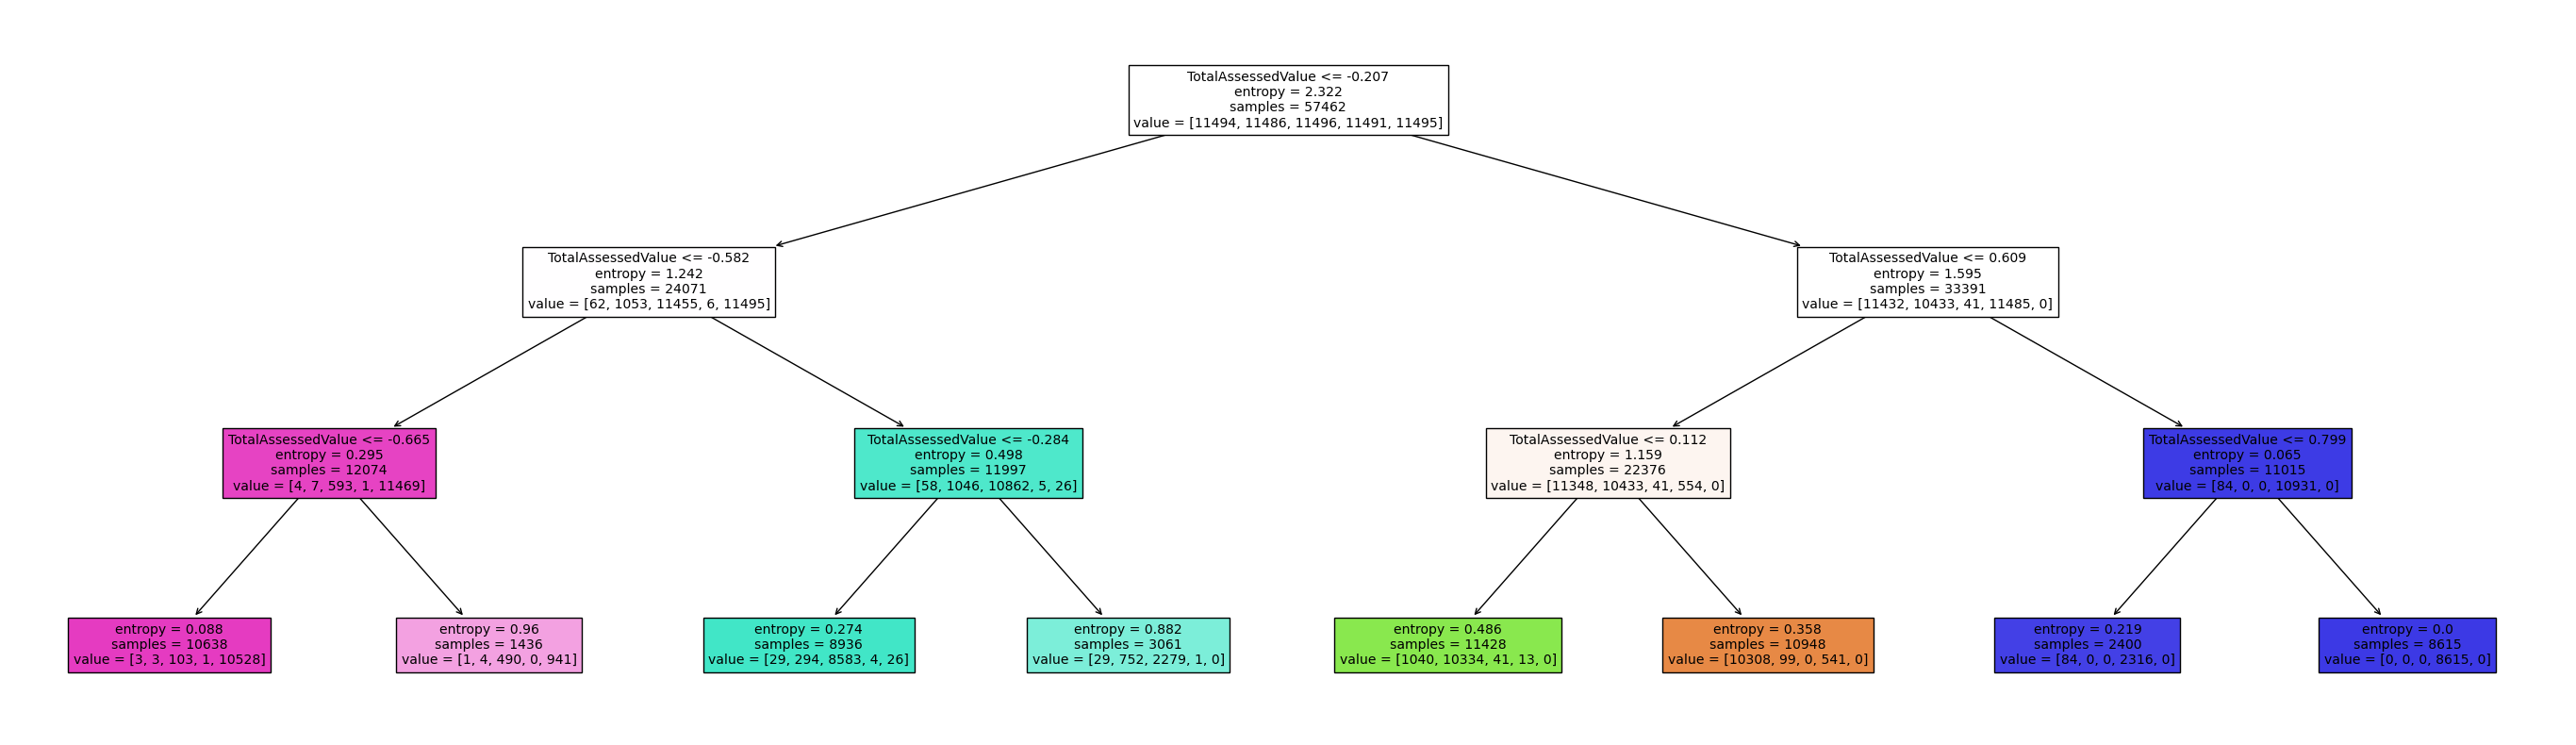

In [12]:
# Plotting tree
clf_tree1 = DecisionTreeClassifier(criterion = "entropy", max_depth = 3, random_state = 0)
clf_tree1.fit(X_train, y_train)

score_test = clf_tree1.score(X_test, y_test)

print(f"DecisionTreeClassifier() score on test data: {score_test:.3f}")

fig = plt.figure(figsize = (35, 10))
_ = tree.plot_tree(clf_tree1, feature_names = ["TotalAssessedValue"], filled = True)
plt.savefig("tree.svg")

### 2. Analyzing how various property characteristics impact a property's value

In [13]:
tr = tr.rename(columns = {"TAV_2022": "2022", "TAV_2021": "2021", "TAV_2020": "2020", "TAV_2019": "2019", 
                          "TAV_2018": "2018", "TAV_2017": "2017", "TAV_2016": "2016"}).stack().to_frame().rename(columns = {0: "TAV"})
tr = tr.reset_index().rename(columns = {"level_1": "Year"})
tr["Year"] = pd.to_datetime(tr["Year"])
tr = tr.groupby("Year")[["TAV"]].mean()


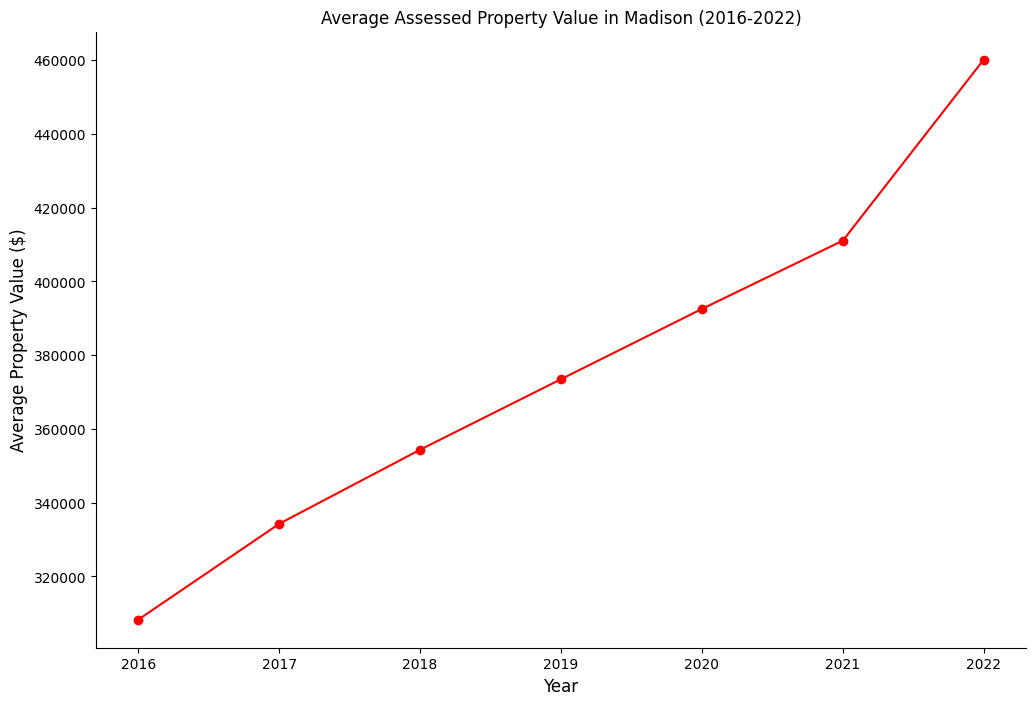

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(tr.index, tr["TAV"], marker = "o", color = "red")

ax.set_ylabel("Average Property Value ($)", fontsize = 12)
ax.set_xlabel("Year", fontsize = 12)
ax.set_title("Average Assessed Property Value in Madison (2016-2022)", fontsize = 12)

sns.despine(ax = ax)
plt.savefig("Trend.svg")
plt.show()

### Question 2(a): Relationship between the age of properties and their average market value

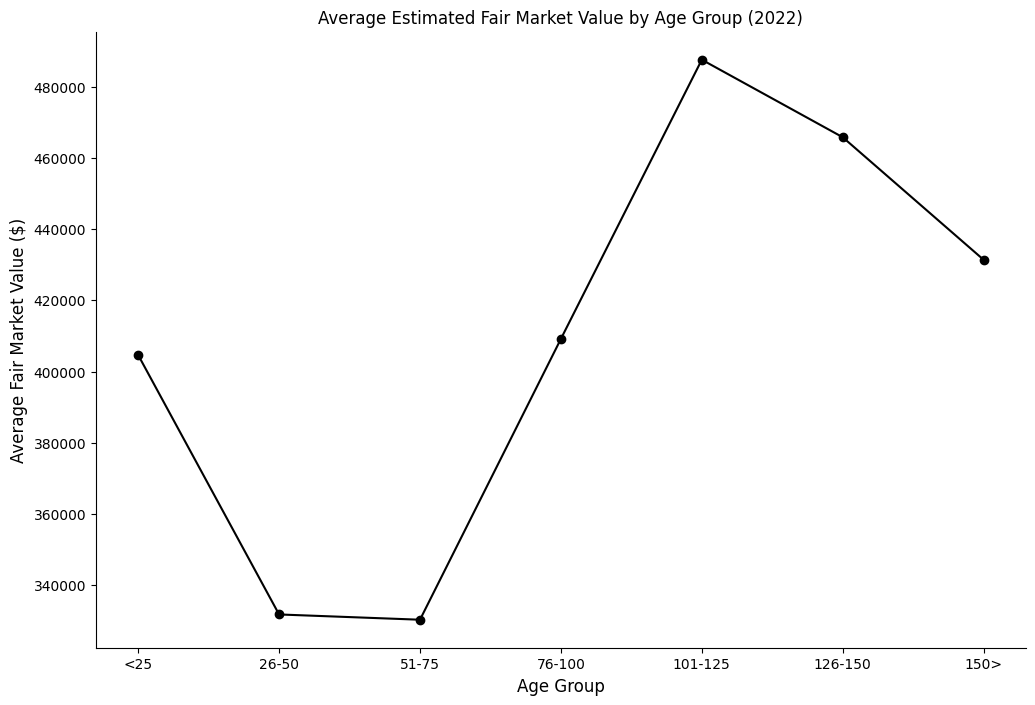

In [15]:
q2a = property_data[["YearBuilt", "EstFairMkt"]]
q2a["age"] = 2023 - q2a["YearBuilt"]
q2a["age"] = q2a["age"].replace([2023], np.nan)

# Adjust bins as needed
bins = [-np.inf,  25,  50,  75, 100, 125, 150, np.inf]  
labels = ["<25", "26-50", "51-75", "76-100", "101-125", "126-150", "150>"]
q2a["AgeGroup"] = pd.cut(q2a["age"], bins = bins, labels = labels, right = False)

# Computint the average estimated fair market values for each age group
avg_estimated_values = q2a.groupby("AgeGroup")["EstFairMkt"].mean().reset_index()

# Creating a bar plot for the average estimated fair market values
plt.figure(figsize=(12, 8))
plt.plot(avg_estimated_values["AgeGroup"], avg_estimated_values["EstFairMkt"], marker = "o", color = "black")
plt.title("Average Estimated Fair Market Value by Age Group (2022)", fontsize = 12)
plt.xlabel("Age Group", fontsize = 12)
plt.ylabel("Average Fair Market Value ($)", fontsize = 12)

sns.despine()
plt.show()

### Question 2(b): Relationship between property type and property value

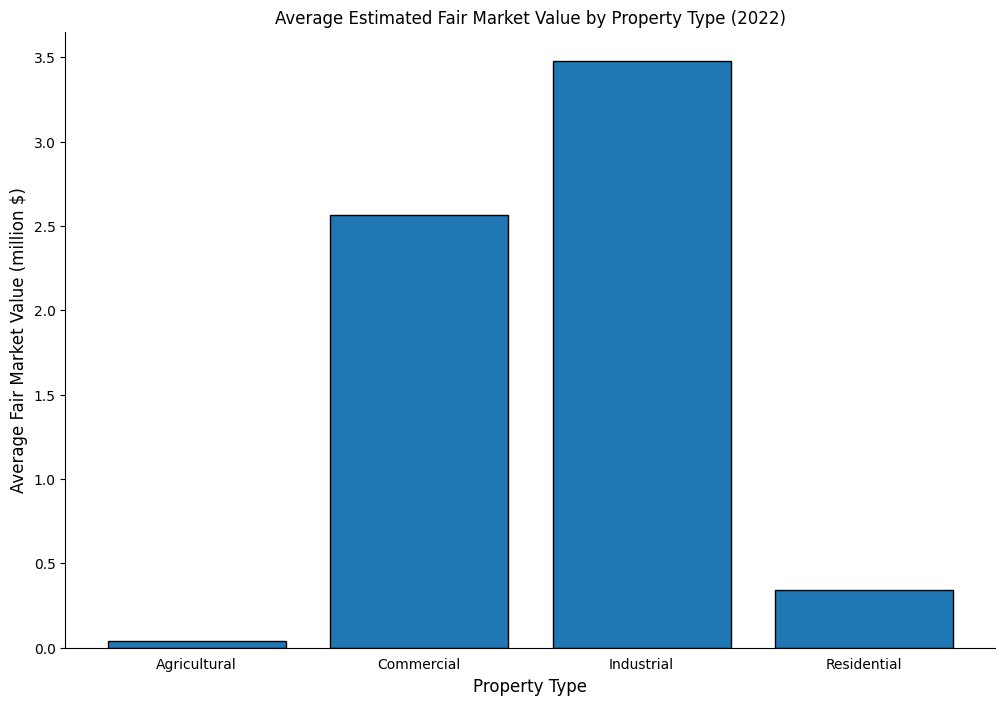

In [16]:
q2b = property_data[["EstFairMkt", "PropertyCl"]]
avg_estimated_value = q2b.groupby("PropertyCl")["EstFairMkt"].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.bar(avg_estimated_value["PropertyCl"], avg_estimated_value["EstFairMkt"] / 1e6, edgecolor = "k")
plt.title("Average Estimated Fair Market Value by Property Type (2022)", fontsize = 12)
plt.xlabel("Property Type", fontsize = 12)
plt.ylabel("Average Fair Market Value (million $)", fontsize = 12)
plt.tick_params(axis = "x", bottom = False)
sns.despine()
plt.show()

### Question 2(c): Impacts of the environment on a property's market value

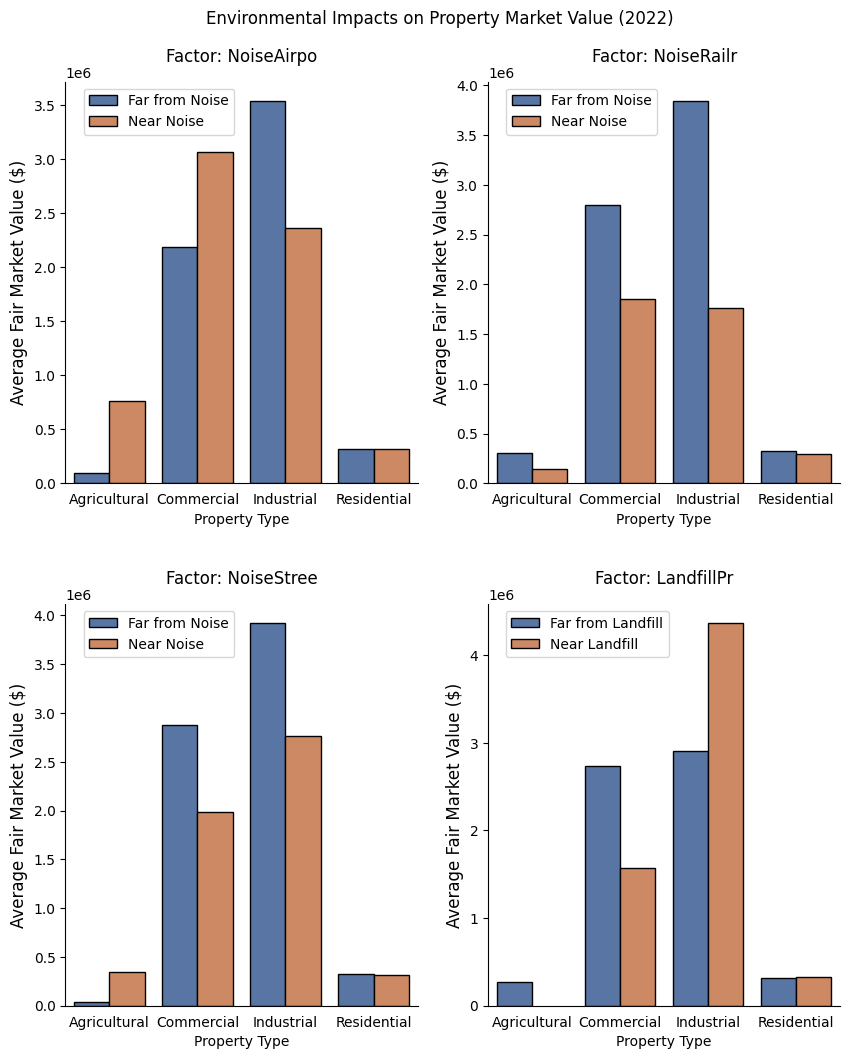

In [17]:
q2c = property_data[["PropertyCl", "NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr", "EstFairMkt"]]
scaler = MinMaxScaler()
columns_to_scale = ["NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"]
q2c[columns_to_scale] = scaler.fit_transform(q2c[columns_to_scale])

q2c = q2c.groupby(["PropertyCl", "NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"])[["EstFairMkt"]].mean().reset_index()

bar_list = ["NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"]

for col in bar_list:
    if col.startswith("Noise"):
        q2c[col] = q2c[col].replace([0, 1], ["Far from Noise", "Near Noise"])
    
    elif col.startswith("Land"):
        q2c[col] = q2c[col].replace([0, 1], ["Far from Landfill", "Near Landfill"])

color_map = ["red", "orange", "green", "tab:blue"]

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 12))
custom_colors = sns.color_palette("deep")

# Plotting box plot
for index, ax in enumerate(axes.flatten()):
    sns.barplot(x = "PropertyCl", y = "EstFairMkt", ax = ax, hue = bar_list[index],
                palette = custom_colors, edgecolor = "black", data = q2c, ci = None)
    ax.set_ylabel("Average Fair Market Value ($)", fontsize = 12)
    ax.set_title(f"Factor: {bar_list[index]}", y = 1.03, fontsize = 12)
    ax.set_xlabel("Property Type")
    ax.tick_params(axis = "x", bottom = False)
    legend = ax.get_legend()
    legend.set_title("")  # Remove the title of the legend 
    legend.set_bbox_to_anchor((0.5, 1))
    
plt.legend(loc = "upper left", bbox_to_anchor = (0.03, 1))
plt.subplots_adjust(hspace = 0.3)
plt.suptitle("Environmental Impacts on Property Market Value (2022)", y = 0.94, fontsize = 12)
sns.despine()
plt.savefig("enviro.svg")
plt.show()

### Question 2(d): Classifying properties based on the environmental aspects

In [18]:
q2d = property_data[["PropertyCl", "NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"]]
q2d[columns_to_scale] = scaler.fit_transform(q2d[columns_to_scale])

# Sampling 30 000 observations from residential properties to reduce computational load and then merging the data back 
residential = q2d[q2d.PropertyCl == "Residential"]
others = q2d[q2d.PropertyCl != "Residential"]
residential = residential.sample(30000, random_state = 0)
q2d = pd.merge(left = residential, right = others, on = ["PropertyCl", "NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"], how = "outer")

X_2d = q2d[["NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"]]
y_2d = q2d["PropertyCl"]

# Train/validation/test split 
X_train, X_tmp, y_train, y_tmp = train_test_split(X_2d, y_2d, test_size = .2, random_state = 0, stratify = y_2d)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size = .5, random_state = 0, stratify = y_tmp)

rs = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = rs.fit_resample(X_train, y_train)


In [19]:
y_train.value_counts()

Residential     24000
Commercial       4140
Agricultural      414
Industrial         91
Name: PropertyCl, dtype: int64

In [20]:
# Comparing models
models = [linear_model.LogisticRegression(), SGDClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()] 

# Parameter dictionaries
parameters_log_reg = {"max_iter": [5000], "C": [0.01, 1, 100, 1000]}
parameters_sgd = {"loss": ["hinge", "log_loss"], "alpha": [0.0001, 0.001, 0.01]}
parameters_id3 = {"criterion": ["entropy"], "max_depth": [1, 3, 5, 7], "min_impurity_decrease": [0, 0.0001, 0.001]}
parameters_kNN = {"metric": ["euclidean", "manhattan"], "n_neighbors": [1, 2, 3, 4], "weights": ["uniform", "distance"]}
all_params = [parameters_log_reg, parameters_sgd, parameters_id3, parameters_kNN]

# Default 'best' values
best_clf = np.NaN
best_clf_index = np.NaN
best_acc_score = -np.Inf

# Looping through each classifier and params, doing grid search to find the best hyperparameter and model
# Scoring against validation set
for i in range(len(models)):
    clf = GridSearchCV(models[i], all_params[i], n_jobs = -1)
    clf.fit(X_resampled, y_resampled)
    score = clf.best_estimator_.score(X_valid, y_valid)
    
    if score >= best_acc_score:
        best_acc_score = score
        best_clf_index = i
        best_clf = clf.best_estimator_

print(f"Index of best classifier: {best_clf_index}")
print(f"Best accuracy score: {best_acc_score:.3f}")
print(f"Best classifier: {best_clf}")
 

Index of best classifier: 3
Best accuracy score: 0.832
Best classifier: KNeighborsClassifier(metric='euclidean', n_neighbors=2)


In [21]:
# Trying stacking
estimators = [
    ("SGD", SGDClassifier(loss = "hinge", alpha = 0.0001, random_state = 0))]

clf = StackingClassifier(
    estimators = estimators, final_estimator = best_clf
)

clf.fit(X_resampled, y_resampled)
print(f"Stacking classifiers score on validation data: {clf.score(X_valid, y_valid):.3f}")

Stacking classifiers score on validation data: 0.827


In [22]:
# Stacking SGD and kNN is not as good as just kNN. Thus, we pick kNN
best_clf.fit(X_resampled, y_resampled)
y_hat = best_clf.predict(X_test)

precision = precision_score(y_true = y_test, y_pred = y_hat, average = "weighted")
recall = recall_score(y_true = y_test, y_pred = y_hat, average = "weighted")

print(f"Precision score on test data: {precision:.3f}")
print(f"Recall score on test data: {recall:.3f}")
print(f"Accuracy score on test data: {best_clf.score(X_test, y_test):.3f}")


Precision score on test data: 0.766
Recall score on test data: 0.834
Accuracy score on test data: 0.834


### Question 2(e): Average residential property value with respect to neighborhood vulnerability

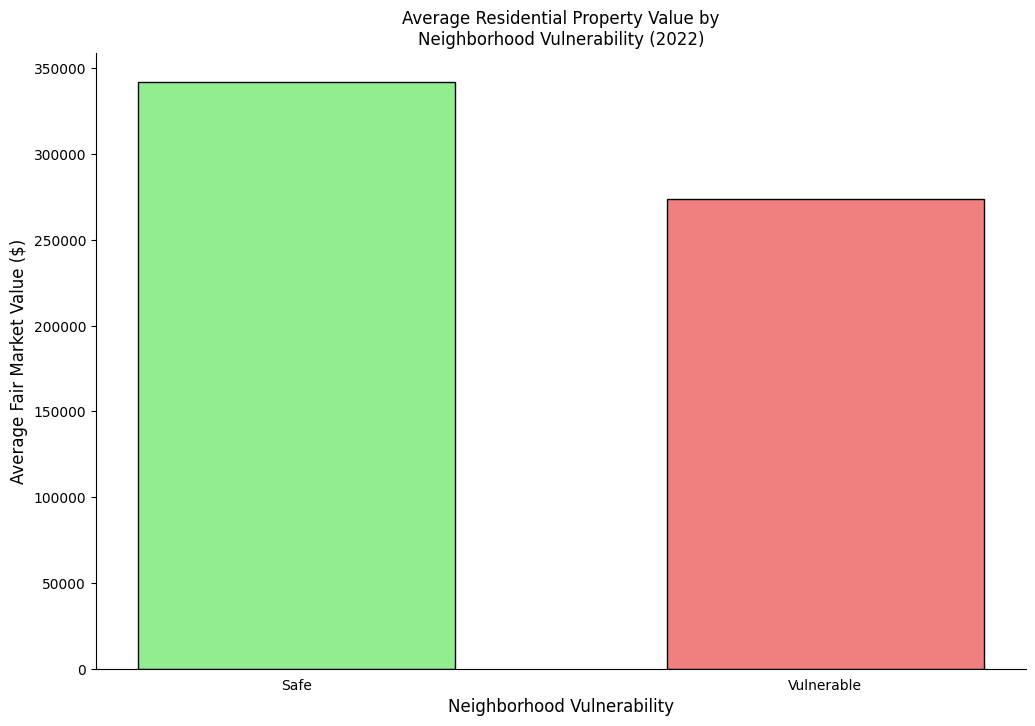

In [23]:
q2e = property_data.copy()
q2e = q2e[q2e["PropertyCl"] == "Residential"]
q2e["Neighbor_3"] = q2e["Neighbor_3"].str.strip()

q2e["Neighbor_3"] = q2e["Neighbor_3"].replace({"0 -": "Safe", "1 - Allied Drive": "Vulnerable",
                                              "3 - Broadway - Simpson": "Vulnerable", "2 - Badger - Magnolia": "Vulnerable",
                                              "99 - Mall-Concourse": "Vulnerable"})

q2e = q2e.groupby("Neighbor_3")["EstFairMkt"].mean().to_frame()

plt.figure(figsize=(12, 8))
plt.bar(q2e.index, q2e["EstFairMkt"], edgecolor = "k", width = 0.6, color = ["lightgreen", "lightcoral"])
plt.xlabel("Neighborhood Vulnerability", fontsize = "12")
plt.ylabel("Average Fair Market Value ($)", fontsize = "12")
plt.tick_params(axis = "x", bottom = False)
plt.title("Average Residential Property Value by\nNeighborhood Vulnerability (2022)")
sns.despine()
plt.show()

### Question 2(f): Extent of how the proximity of bus stops affect the value of a residential property 

In [24]:
# Setting up data
q2f = property_data.copy()
q2f = q2f[q2f["PropertyCl"] == "Residential"]
q2f["Value"] = (q2f["EstFairMkt"] > q2f["EstFairMkt"].quantile(0.5)).astype(int)

X_2f = q2f[["DistanceToStop"]]
y_2f = q2f["Value"]

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_2f, y_2f, test_size = 0.2, random_state = 0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

# Feature scaling 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)


In [25]:
# Comparing models
models = [RandomForestClassifier(), GradientBoostingClassifier()]

# Parameter dictionaries
parameters_rfc = {"criterion": ["gini"], "max_depth": [1, 3, 5, 7, 9], "min_samples_split": [2, 3, 4], "random_state": [0]}
parameters_gbc = {"n_estimators": [100, 200], "max_depth": [ 2, 3, 4], "learning_rate": [0.001, 0.01, 0.1], "random_state": [0]}
all_params = [parameters_rfc, parameters_gbc]

# Default 'best' values
best_acc_score = -np.Inf
best_clf = np.NaN
best_clf_index = np.NaN

# Looping through each classifier and params, doing grid search to find the best hyperparameter and model
# Scoring against validation set
for i in range(len(models)):
    clf = GridSearchCV(models[i], all_params[i], n_jobs = -1)
    clf.fit(X_train, y_train)
    score = clf.best_estimator_.score(X_valid, y_valid)
    
    if score > best_acc_score:
        best_clf_index = i
        best_acc_score = score
        best_clf = clf.best_estimator_

print(f"Index of best classifier: {best_clf_index}")
print(f"Best accuracy score: {best_acc_score:.3f}")
print(f"Best classifier(s): {best_clf}")
 

Index of best classifier: 0
Best accuracy score: 0.630
Best classifier(s): RandomForestClassifier(max_depth=9, min_samples_split=3, random_state=0)


In [26]:
# As RandomForestClassifier is the best model, we try to tune the hyperparameters further
parameters_rfc2 = {"criterion": ["gini"], 
                   "max_depth": [9, 11, 13, 15], "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9], "random_state": [0]}
new_clf = GridSearchCV(RandomForestClassifier(), parameters_rfc2, n_jobs = -1)

new_clf.fit(X_train, y_train)
print(f"Accuracy score on validation data: {new_clf.best_estimator_.score(X_valid, y_valid):.3f}")

Accuracy score on validation data: 0.631


Precision score on test data: 0.627
Recall score on test data: 0.755
Accuracy score on test data: 0.646


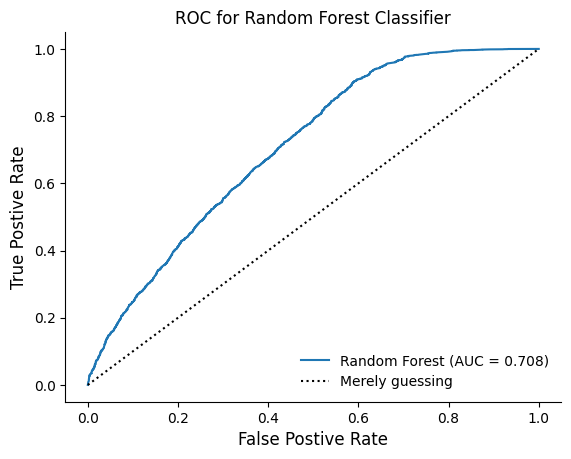

In [27]:
# Calculating the various metrics for a classification model
y_hat = new_clf.predict(X_test)

precision = precision_score(y_true = y_test, y_pred = y_hat)
recall = recall_score(y_true = y_test, y_pred = y_hat)

probability_y_is_1 = new_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_true = y_test, y_score = probability_y_is_1)


print(f"Precision score on test data: {precision:.3f}")
print(f"Recall score on test data: {recall:.3f}")
print(f"Accuracy score on test data: {new_clf.best_estimator_.score(X_test, y_test):.3f}")

# Displaying ROC curve
RocCurveDisplay.from_estimator(new_clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ":k", label = "Merely guessing")
plt.title("ROC for Random Forest Classifier", fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 12)
plt.xlabel("False Positive Rate", fontsize = 12)
sns.despine()
legend = plt.legend(frameon = False, loc = "lower right")
legend.texts[0].set_text(f"Random Forest (AUC = {auc:.3f})")  

plt.show()

### Question 2(g): Identifying property values based on physical features

In [49]:
# Data setup
q2g = property_data[["HomeStyle", "EstFairMkt", "LotSize", "TotalLivin", "Bedrooms", "FullBaths", "HalfBaths", "Basement", "ExteriorWa",
                     "Exterior_1", "Fireplaces", "CentralAir", "LocalHisto", "NationalHi", "Elementary", "MiddleScho", "HighSchool", "PropertyCl", "OnBusLine", "Neighbor_3"]]

q2g = q2g.dropna(subset=["HomeStyle"])

q2g = q2g[q2g["PropertyCl"] == "Residential"].drop("PropertyCl", axis = 1)
q2g = q2g[(q2g["Elementary"] != "To be determined") & (q2g["Elementary"] != "Assigned")]
q2g = q2g[(q2g["MiddleScho"] != "To be determined") & (q2g["MiddleScho"] != "Assigned")]
q2g = q2g[(q2g["HighSchool"] != "Optional")]

def school_dist(x):
    if x.notna().any():
        return 1
    else:
        return 0
    
q2g["OnSchoolDist"] = q2g[["Elementary", "MiddleScho", "HighSchool"]].apply(school_dist, axis = 1)
q2g = q2g.drop(["Elementary", "MiddleScho", "HighSchool"], axis = 1)

def exteriors(x):
    if pd.isna(x["ExteriorWa"]) and pd.isna(x["Exterior_1"]):
        return "No exteriors"
    elif pd.isna(x["ExteriorWa"]) and not pd.isna(x["Exterior_1"]):
        return x["Exterior_1"]
    elif not pd.isna(x["ExteriorWa"]) and pd.isna(x["Exterior_1"]):
        return x["ExteriorWa"]
    else:
        return f"{x['ExteriorWa']}, {x['Exterior_1']}"
    
q2g["Exteriors"] = q2g.apply(exteriors, axis=1)
q2g = q2g.drop(["ExteriorWa", "Exterior_1"], axis = 1)

q2g["Neighbor_3"] = q2g["Neighbor_3"].replace({"0 -": "Safe", "1 - Allied Drive": "Vulnerable",
                                              "3 - Broadway - Simpson": "Vulnerable", "2 - Badger - Magnolia": "Vulnerable",
                                              "99 - Mall-Concourse": "Vulnerable"})

q2g["Neighbor_3"] = q2g["Neighbor_3"].replace({"Safe": 0, "Vulnerable": 1})

q2g["CentralAir"] = q2g["CentralAir"].replace({"YES": 1, "NO": 0})
q2g["OnBusLine"] = q2g["OnBusLine"].replace({True: 1, False: 0})
q2g["LocalHisto"] = q2g["LocalHisto"].replace({"-": "Not a Historic District"})

q2g = q2g.rename(columns = {"Neighbor_3": "NborVulnerability"})


q2g = q2g.sample(25000, random_state = 0)

In [50]:
# Feature selection - Part 1 (finding best alpha for regularization)
X_2g = q2g.drop(["EstFairMkt"], axis = 1)
y_2g = q2g["EstFairMkt"]

ohe_cols = ["HomeStyle", "Exteriors", "LocalHisto"]
sc_cols = ["LotSize", "TotalLivin", "Bedrooms", "FullBaths", "HalfBaths", "Basement", "Fireplaces"]

total_transformed_cols = ohe_cols + sc_cols
remaining_cols = X_2g.columns.difference(total_transformed_cols).tolist()

# Finding best alpha value
column_transformer = make_column_transformer(
            (StandardScaler(), sc_cols),
            (OneHotEncoder(), ohe_cols),
            ("passthrough", remaining_cols)
        )

alpha_range = np.logspace(1, 10, 50)
parameters_lasso = {"lasso__alpha": alpha_range}

lasso_lm = linear_model.Lasso(random_state = 0)

pipeline = Pipeline([
    ("transformers", column_transformer),
    ("lasso", lasso_lm)
])

grid = GridSearchCV(pipeline, parameters_lasso, n_jobs = -1)
grid.fit(X_2g, y_2g)
best_alpha = grid.best_estimator_.named_steps["lasso"].alpha

In [51]:
# Feature selection - Part 2 (Finding the relevant features)
feature_selection_model = Pipeline([
    ("transformers", column_transformer),
    ("lasso", linear_model.Lasso(alpha = best_alpha, random_state = 0))
])

feature_selection_model.fit(X_2g, y_2g)

# Getting the coefficients
coefficients = feature_selection_model.named_steps["lasso"].coef_

# # Identifying non-zero coefficients
transformer = feature_selection_model.named_steps["transformers"]  
transformed_feature_names = transformer.get_feature_names_out()
selected_features = transformed_feature_names[coefficients != 0]


print(f"Number of features before LASSO: {len(transformed_feature_names)}")
print(f"Number of features after LASSO: {len(selected_features)}")

Number of features before LASSO: 107
Number of features after LASSO: 87


In [52]:
# Columns to be dropped
remove_cols = list(set(transformed_feature_names) - set(selected_features))
remove_cols = [feature.replace("onehotencoder__", "") for feature in remove_cols]
remove_cols = [feature.replace("passthrough__", "") for feature in remove_cols]

In [53]:
# Filtering out the irrelevant columns
X = q2g.drop(["EstFairMkt"], axis = 1)
remaining_cols = X.columns.difference(ohe_cols).tolist()

preprocessor = make_column_transformer(
        (OneHotEncoder(), ohe_cols),
        ("passthrough", remaining_cols)
)

X = preprocessor.fit_transform(X)
get_col_names = preprocessor.get_feature_names_out()
get_col_names = [feature.replace("onehotencoder__", "") for feature in get_col_names]
get_col_names = [feature.replace("passthrough__", "") for feature in get_col_names]

X = pd.DataFrame.sparse.from_spmatrix(X)
X.columns = get_col_names
X = X.drop(remove_cols, axis = 1)

# Finalized features/ target variable to use for machine learning
y_2g = y_2g.reset_index().drop("Parcel", axis = 1)
y_2g = (y_2g["EstFairMkt"] > y_2g["EstFairMkt"].median()).astype(int)

X = X.sparse.to_dense()
X.head(2)

,HomeStyle_Apartment,HomeStyle_Bi-level,HomeStyle_Bungalow,HomeStyle_Cape Cod,HomeStyle_Colonial,HomeStyle_Contemporary,HomeStyle_Cottage,HomeStyle_Flat,HomeStyle_Garden,HomeStyle_Garden with loft,...,CentralAir,Fireplaces,FullBaths,HalfBaths,LotSize,NationalHi,NborVulnerability,OnBusLine,OnSchoolDist,TotalLivin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2.0,1.0,12600.0,0.0,0.0,1.0,1.0,1339.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,9805.0,0.0,0.0,1.0,1.0,960.0


In [54]:
# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_2g, test_size = 0.2, random_state = 0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

# Feature scaling 
sc = StandardScaler()
X_train[sc_cols] = sc.fit_transform(X_train[sc_cols])
X_valid[sc_cols] = sc.transform(X_valid[sc_cols])
X_test[sc_cols] = sc.transform(X_test[sc_cols])

In [55]:
# Hyperparameter tuning
models = [DecisionTreeClassifier(random_state = 0), KNeighborsClassifier(), linear_model.LogisticRegression(random_state = 0)]

params_id3 = {"criterion": ["entropy"],
             "max_depth": [1, 3, 5, 10]}

params_log = {"max_iter": [5000],
             "C": [0.01, 1, 100, 1000]}

params_kNN = {"n_neighbors": [1, 2, 3, 4, 5],
             "metric": ["euclidean", "manhattan"]}

parameters = [params_id3, params_kNN, params_log]

for model, param in zip(models, parameters):
    clf = GridSearchCV(model, param, n_jobs = -1)
    clf.fit(X_train, y_train)
    best_score = clf.score(X_valid, y_valid) # best score for each model
    
    print(f"For {model}, the best score is {best_score:.3f}")
    print(f"Best parameters: {clf.best_params_}")

For DecisionTreeClassifier(random_state=0), the best score is 0.843
Best parameters: {'criterion': 'entropy', 'max_depth': 10}
For KNeighborsClassifier(), the best score is 0.845
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
For LogisticRegression(random_state=0), the best score is 0.853
Best parameters: {'C': 1, 'max_iter': 5000}


In [56]:
# Trying ensemble learning - gradient boosting
gboost = GradientBoostingClassifier()

# Parameter dictionary
parameters_gbc = {"n_estimators": [100], "max_depth": [3, 5, 7, 9], "learning_rate": [0.001, 0.01, 0.1], "random_state": [0]}
clf = GridSearchCV(gboost, parameters_gbc, n_jobs = -1)
clf.fit(X_train, y_train)
score = clf.best_estimator_.score(X_valid, y_valid)

print(f"Best accuracy score on validation data: {score:.3f}")
print(f"Best hyperparameter: {clf.best_params_}") 

Best accuracy score on validation data: 0.868
Best hyperparameter: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'random_state': 0}


Precision score on test data: 0.868
Recall score on test data: 0.852
Accuracy score on test data: 0.858


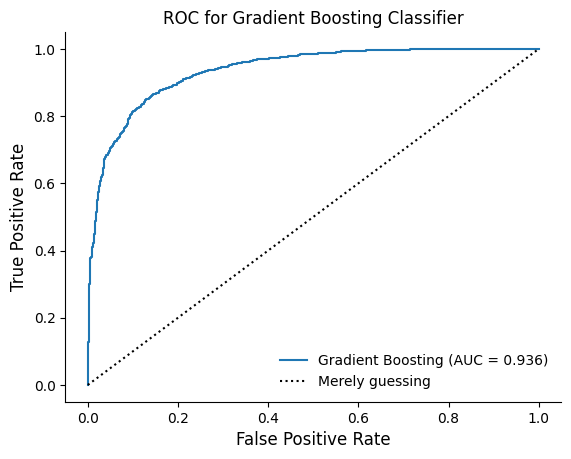

In [57]:
# Gradient boosting classifier outperforms other models, thus we choose to proceed with this model

# Calculating the various metrics for a classification model
y_hat = clf.predict(X_test)

precision = precision_score(y_true = y_test, y_pred = y_hat)
recall = recall_score(y_true = y_test, y_pred = y_hat)

probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_true = y_test, y_score = probability_y_is_1)

print(f"Precision score on test data: {precision:.3f}")
print(f"Recall score on test data: {recall:.3f}")
print(f"Accuracy score on test data: {clf.best_estimator_.score(X_test, y_test):.3f}")

# Displaying ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ":k", label = "Merely guessing")
plt.title("ROC for Gradient Boosting Classifier", fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 12)
plt.xlabel("False Positive Rate", fontsize = 12)
sns.despine()
legend = plt.legend(frameon = False, loc = "lower right")
legend.texts[0].set_text(f"Gradient Boosting (AUC = {auc:.3f})")  

plt.savefig("gbc.svg")
plt.show()


### 3. Bringing it all together: Constructing an accurate model to predict a residential property's market value

In [58]:
# Procedure is fairly similar to previous question

# Data setup
q3 = property_data[["EstFairMkt", "PropertyUs", "AreaName", "HomeStyle", "YearBuilt", "LotSize", "TotalLivin", "Bedrooms", "FullBaths", 
                    "HalfBaths", "Basement", "ExteriorWa", "Exterior_1", "Fireplaces", "CentralAir", "ZoningAll", "LocalHisto", "NationalHi", 
                    "Elementary", "MiddleScho", "HighSchool", "NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr",
                    "PropertyCl", "OnBusLine", "Neighbor_3"]]

q3 = q3.dropna(subset=["HomeStyle"])

q3 = q3[q3["PropertyCl"] == "Residential"].drop("PropertyCl", axis = 1)
q3 = q3[(q3["Elementary"] != "To be determined") & (q3["Elementary"] != "Assigned")]
q3 = q3[(q3["MiddleScho"] != "To be determined") & (q3["MiddleScho"] != "Assigned")]
q3 = q3[(q3["HighSchool"] != "Optional")]
    
q3["OnSchoolDist"] = q3[["Elementary", "MiddleScho", "HighSchool"]].apply(school_dist, axis = 1)
q3 = q3.drop(["Elementary", "MiddleScho", "HighSchool"], axis = 1)
    
q3["Exteriors"] = q3.apply(exteriors, axis = 1)
q3 = q3.drop(["ExteriorWa", "Exterior_1"], axis = 1)

q3["Neighbor_3"] = q3["Neighbor_3"].replace({"0 -": "Safe", "1 - Allied Drive": "Vulnerable",
                                             "3 - Broadway - Simpson": "Vulnerable", "2 - Badger - Magnolia": "Vulnerable",
                                             "99 - Mall-Concourse": "Vulnerable"})

q3["Neighbor_3"] = q3["Neighbor_3"].replace({"Safe": 0, "Vulnerable": 1})

q3["CentralAir"] = q3["CentralAir"].replace({"YES": 1, "NO": 0})
q3["OnBusLine"] = q3["OnBusLine"].replace({True: 1, False: 0})
q3["LocalHisto"] = q3["LocalHisto"].replace({"-": "Not a Historic District"})

scaler = MinMaxScaler()
columns_to_scale = ["NoiseAirpo", "NoiseRailr", "NoiseStree", "LandfillPr"]
q3[columns_to_scale] = scaler.fit_transform(q3[columns_to_scale])

q3["Age"] = 2023 - q3["YearBuilt"]
q3["Age"] = q3["Age"].replace([2023], np.nan)
q3 = q3.drop("YearBuilt", axis = 1)
q3 = q3.dropna(subset = ["Age"])

q3 = q3.rename(columns = {"Neighbor_3": "NborVulnerability"})

# 15000 data to reduce computational load
q3 = q3.sample(15000, random_state = 0)

In [59]:
# Feature selection - Part 1 (finding best alpha for regularization)
X_3 = q3.drop(["EstFairMkt"], axis = 1)
y_3 = q3["EstFairMkt"]

ohe_cols = ["PropertyUs", "AreaName", "HomeStyle", "ZoningAll", "Exteriors", "LocalHisto"]
sc_cols = ["LotSize", "TotalLivin", "Bedrooms", "FullBaths", "HalfBaths", "Basement", "Fireplaces", "Age"]

total_transformed_cols = ohe_cols + sc_cols
remaining_cols = X_3.columns.difference(total_transformed_cols).tolist()

# Finding best alpha value
column_transformer = make_column_transformer(
            (StandardScaler(), sc_cols),
            (OneHotEncoder(), ohe_cols),
            ("passthrough", remaining_cols)
        )

alpha_range = np.logspace(1, 10, 50)
parameters_lasso = {"lasso__alpha": alpha_range}

lasso_lm = linear_model.Lasso(random_state = 0)

pipeline = Pipeline([
    ("transformers", column_transformer),
    ("lasso", lasso_lm)
])

grid = GridSearchCV(pipeline, parameters_lasso, n_jobs = -1)
grid.fit(X_3, y_3)
best_alpha = grid.best_estimator_.named_steps["lasso"].alpha

In [60]:
# Feature selection - Part 2 (Finding the relevant features)
feature_selection_model = Pipeline([
    ("transformers", column_transformer),
    ("lasso", linear_model.Lasso(alpha = best_alpha, random_state = 0))
])

feature_selection_model.fit(X_3, y_3)

# Getting the coefficients
coefficients = feature_selection_model.named_steps["lasso"].coef_

# # Identifying non-zero coefficients
transformer = feature_selection_model.named_steps["transformers"]  
transformed_feature_names = transformer.get_feature_names_out()
selected_features = transformed_feature_names[coefficients != 0]


print(f"Number of features before LASSO: {len(transformed_feature_names)}")
print(f"Number of features after LASSO: {len(selected_features)}")

Number of features before LASSO: 583
Number of features after LASSO: 403


In [61]:
# Columns to be dropped
remove_cols = list(set(transformed_feature_names) - set(selected_features))
remove_cols = [feature.replace("onehotencoder__", "") for feature in remove_cols]
remove_cols = [feature.replace("passthrough__", "") for feature in remove_cols]
remove_cols = [feature.replace("standardscaler__", "") for feature in remove_cols]

In [62]:
# Filtering out the irrelevant columns
X = q3.drop(["EstFairMkt"], axis = 1)
remaining_cols = X.columns.difference(ohe_cols).tolist()

preprocessor = make_column_transformer(
        (OneHotEncoder(), ohe_cols),
        ("passthrough", remaining_cols)
)

X = preprocessor.fit_transform(X)
get_col_names = preprocessor.get_feature_names_out()
get_col_names = [feature.replace("onehotencoder__", "") for feature in get_col_names]
get_col_names = [feature.replace("passthrough__", "") for feature in get_col_names]

X = pd.DataFrame.sparse.from_spmatrix(X)
X.columns = get_col_names
X = X.drop(remove_cols, axis = 1)

# Finalized features/ target variable to use for machine learning
y_3 = y_3.reset_index().drop("Parcel", axis = 1)
X = X.sparse.to_dense()
X.head(2)

,PropertyUs_3 unit Apartment,PropertyUs_4 unit Apartment,PropertyUs_5 unit Apartment,PropertyUs_6 unit Apartment,PropertyUs_7 unit Apartment,PropertyUs_Condominium,PropertyUs_Single family,AreaName_2 units in Area 115,AreaName_2 units in Res Area 118,AreaName_3 Units in Res Area 17,...,FullBaths,HalfBaths,LandfillPr,LotSize,NationalHi,NoiseAirpo,NoiseStree,OnBusLine,OnSchoolDist,TotalLivin
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,1.0,0.0,12600.0,0.0,0.0,0.0,1.0,1.0,1339.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,9805.0,0.0,0.0,0.0,1.0,1.0,960.0


In [63]:
# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_3, test_size = 0.2, random_state = 0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

# Feature scaling 
sc_cols = ["LotSize", "TotalLivin", "FullBaths", "HalfBaths", "Basement", "Fireplaces", "Age"]

sc = StandardScaler()
X_train[sc_cols] = sc.fit_transform(X_train[sc_cols])
X_valid[sc_cols] = sc.transform(X_valid[sc_cols])
X_test[sc_cols] = sc.transform(X_test[sc_cols])

In [64]:
# Hyperparameter tuning and model selection
models = [DecisionTreeRegressor(random_state = 0), KNeighborsRegressor(), linear_model.LinearRegression(), 
          SGDRegressor(random_state = 0)]

params_id3 = {"criterion": ["squared_error", "friedman_mse"],
             "max_depth": [1, 3, 5, 10, 15, 20]}

params_kNN = {"n_neighbors": [1, 3, 5, 7],
             "metric": ["euclidean", "manhattan"]}

params_lm = {}

params_sgd = {"loss": ["squared_error"], "alpha": [0.0001, 0.001, 0.01, 0.1]}

parameters = [params_id3, params_kNN, params_lm, params_sgd]

for model, param in zip(models, parameters):
    clf = GridSearchCV(model, param, n_jobs = -1)
    clf.fit(X_train, y_train)
    best_score = clf.score(X_valid, y_valid) # best score for each model
    
    print(f"For {model}, the best R^2 score is {best_score:.3f}")
    print(f"Best parameters: {clf.best_params_}\n")

For DecisionTreeRegressor(random_state=0), the best R^2 score is 0.750
Best parameters: {'criterion': 'squared_error', 'max_depth': 20}

For KNeighborsRegressor(), the best R^2 score is 0.767
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}

For LinearRegression(), the best R^2 score is 0.842
Best parameters: {}

For SGDRegressor(random_state=0), the best R^2 score is 0.826
Best parameters: {'alpha': 0.0001, 'loss': 'squared_error'}



In [65]:
# Trying random forest 
rf = RandomForestRegressor()

# Parameter dictionary
parameters_rf = {"n_estimators": [100], "max_depth": [3, 5, 7, 9], "criterion": ["squared_error", "friedman_mse"], "random_state": [0]}
clf = GridSearchCV(rf, parameters_rf, n_jobs = -1)
clf.fit(X_train, y_train)
score = clf.best_estimator_.score(X_valid, y_valid)

print(f"Best R^2 score on validation data: {score:.3f}")
print(f"Best hyperparameter: {clf.best_params_}")


Best R^2 score on validation data: 0.795
Best hyperparameter: {'criterion': 'squared_error', 'max_depth': 9, 'n_estimators': 100, 'random_state': 0}


In [66]:
# Trying gradient boosting
gboost = GradientBoostingRegressor()

# Parameter dictionary
parameters_gbc = {"loss": ["squared_error", "huber"], "n_estimators": [100], "max_depth": [3, 5, 7, 9], "learning_rate": [0.001, 0.01, 0.1], "random_state": [0]}
clf = GridSearchCV(gboost, parameters_gbc, n_jobs = -1)
clf.fit(X_train, y_train)
score = clf.best_estimator_.score(X_valid, y_valid)

print(f"Best R^2 score on validation data: {score:.3f}")
print(f"Best hyperparameter: {clf.best_params_}") 

Best R^2 score on validation data: 0.870
Best hyperparameter: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 100, 'random_state': 0}


In [67]:
# Gradient boosting regressor outperforms other models, thus we choose to proceed with this model

print(f"R^2 score on test data: {clf.best_estimator_.score(X_test, y_test):.3f}")

R^2 score on test data: 0.881


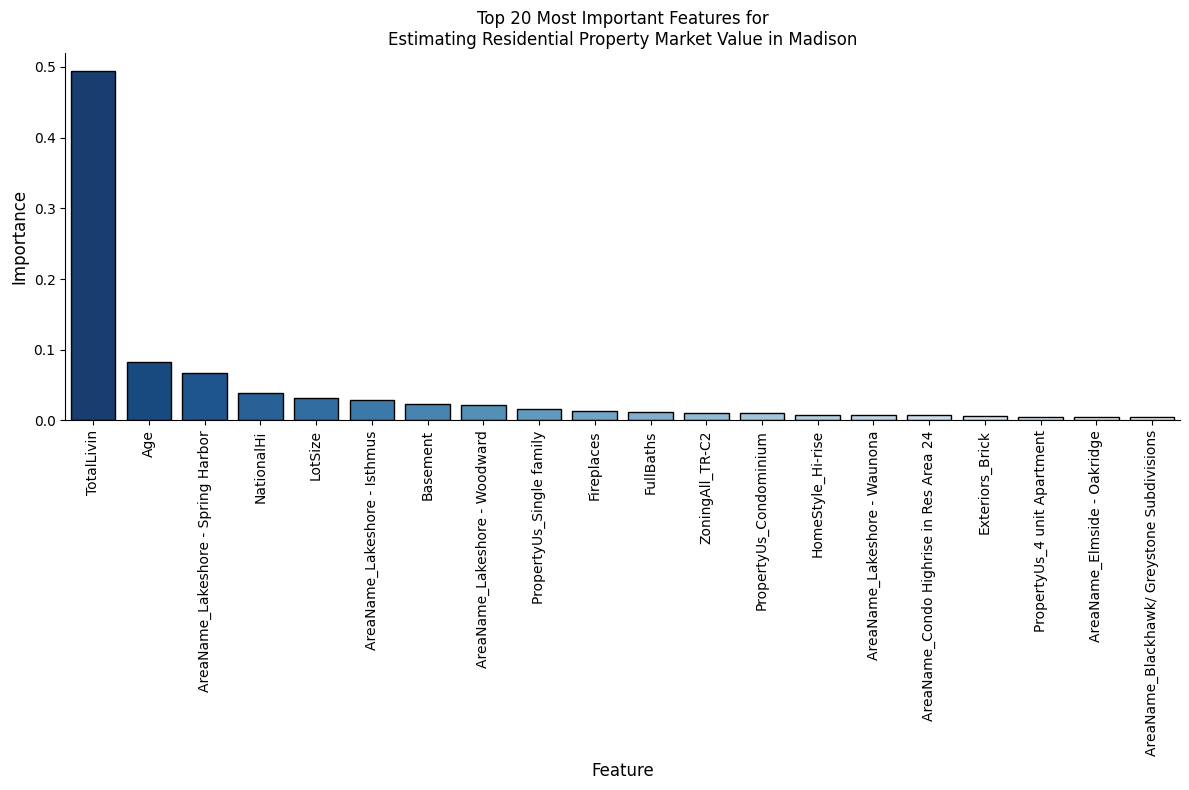

In [68]:
# Plotting feature importance

feature_importances = clf.best_estimator_.feature_importances_
get_features = X_train.columns

importances = list(zip(get_features, feature_importances))
importances = sorted(importances, key = lambda x: x[1], reverse = True)
top = importances[:20]

plot_imp = pd.DataFrame(top, columns = ["Feature", "Importance"])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x = "Feature", y = "Importance", ax = ax,
            edgecolor = "black", data = plot_imp, palette = "Blues_r")

plt.xlabel("Feature", fontsize = 12)
plt.ylabel("Importance", fontsize = 12)
plt.title("Top 20 Most Important Features for\nEstimating Residential Property Market Value in Madison")

ax.tick_params(axis = "x", rotation = 90)

sns.despine(ax = ax)
plt.tight_layout()
plt.savefig("feat_imp.svg")
plt.show()

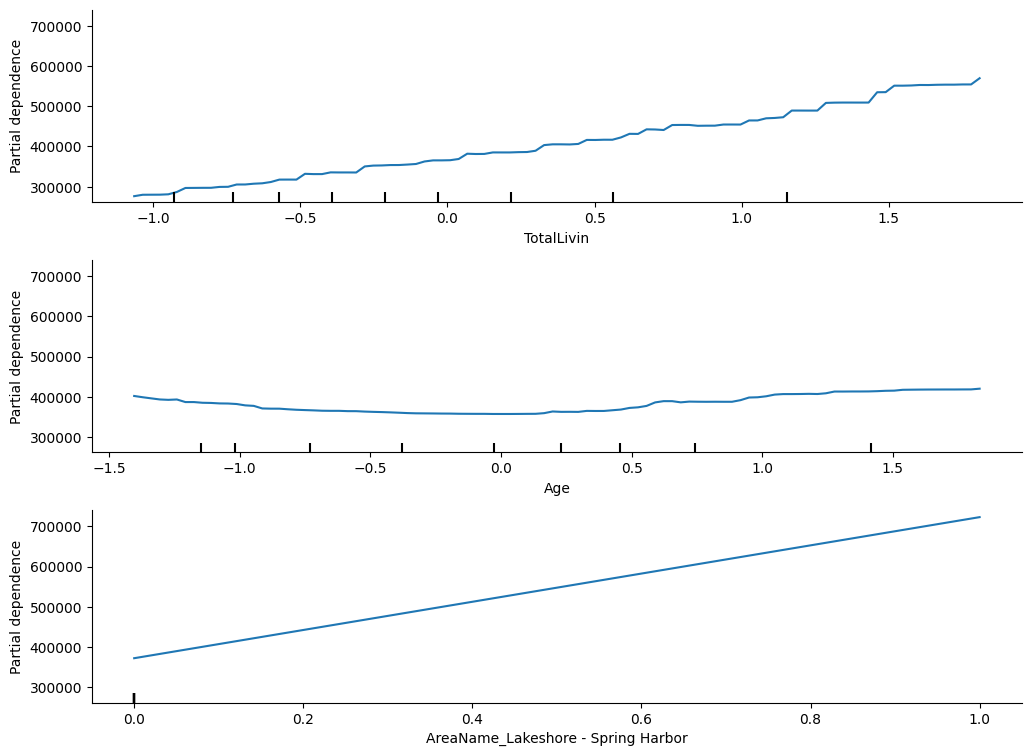

In [72]:
# Partial dependence plot

fig, ax = plt.subplots(len(plot_imp["Feature"][0:3].to_list()), figsize=(12, len(plot_imp["Feature"][0:3].to_list()) * 3))
plt.subplots_adjust(hspace = 0.3)
PartialDependenceDisplay.from_estimator(clf, X_train, features= plot_imp["Feature"][0:3].to_list(), ax=ax)
sns.despine()
plt.show()